In [36]:
import openai
from dotenv import find_dotenv, load_dotenv
from youtube_transcript_api import YouTubeTranscriptApi
import streamlit as st
from langchain import OpenAI
from langchain.docstore.document import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.chains.summarize import load_summarize_chain
from langchain.prompts import PromptTemplate
import os

current_directory = os.getcwd()
load_dotenv(current_directory + '/conf.env')

OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')

def inner_vector_product(vector_1, vector_2):
    """
    This function calculates the inner vector product of two vectors.
    """
    import numpy as np
    a = np.array(vector_1)
    b = np.array(vector_2)

    return np.dot(a, b)

In [179]:
import sqlite3

# create a connection to the database
conn = sqlite3.connect('b-questions.db')

# check if the table exists, if not create it
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table' AND name='behavioral_question'")
table_exists = cursor.fetchone()
if not table_exists:
    conn.execute('''CREATE TABLE behavioral_question
                 (question TEXT,
                 tags TEXT);''')

# insert a new question into the table
conn.execute('''INSERT INTO behavioral_question (question, tags) VALUES ('Tell me about a time when 
you had to deal with a difficult customer', 'customer service')''')

# commit the changes
conn.commit()

# close the connection
conn.close()


In [45]:
INTERVIEW_QUESTION = "Tell me about the time that you solved the customer's problem."

In [38]:
# Download sample video transcript
transcript = YouTubeTranscriptApi.get_transcript('CR8Niz9DrWU&t=6s')
res = ''
for txt in transcript:
    res += ' ' + txt['text']

with open(current_directory + '/interview_1.txt', 'w', encoding='utf-8') as interview:
    interview.write(res)  

In [39]:
def generate_response(txt):
    # Instantiate the LLM model
    llm = OpenAI(temperature = 0.0, 
                 openai_api_key = OPENAI_API_KEY)
    
    # Split text
    text_splitter = RecursiveCharacterTextSplitter(
    # Set a really small chunk size, just to show.
    chunk_size = 1500,
    chunk_overlap  = 20,
    length_function = len,
    add_start_index = True,)
    
    texts = text_splitter.split_text(txt)
    # Create multiple documents
    docs = [Document(page_content=t) for t in texts]
    # Text summarization
    chain = load_summarize_chain(llm, chain_type='map_reduce')
    return chain.run(docs)

summerized_text = generate_response(res)

In [40]:
INTERVIEW_QUESTION_PROMPT = """ We asked a candidate an interview question of {interview_question}. 
Here is the sumerized response: {candidate_response} 

Question : How do you evaluate the candidate's response?

Instructions:

1) The story should be specific about an industrial project in the domain of 
   engineering, product or marketing.
2) The story should be clear and easy to understand.
3) The story should be relevant to the question.

Please use the following template for your response :

Your general ranking should be only one of these choices:

1) weak, 
2) average, 
3) strong

With the Explanation of your ranking follow by word AI_REASONS:"""

In [46]:
prompt_template = PromptTemplate(
    input_variables =["candidate_response", "interview_question"],
    template = INTERVIEW_QUESTION_PROMPT
)

query = prompt_template.format(
        candidate_response = summerized_text,
        interview_question = INTERVIEW_QUESTION
    )

In [47]:
llm = OpenAI(temperature = 0.0, openai_api_key = OPENAI_API_KEY)
print(llm(query))



The candidate's response is strong. AI_REASONS: The candidate provided a detailed story that was specific to the domain of product management, was clear and easy to understand, and was relevant to the question.


In [43]:
LEADERSHIP_PRINCIPLES ={ "CUSTOMER_OBSESSION" : """"
The core factor in the leadership principle of "Customer Obsession" is an unwavering commitment to prioritizing the customer above 
all else. This principle emphasizes understanding customer needs and preferences to guide decision-making. It places the customer at 
the center of all operations, striving to exceed expectations and adapt to changing needs. This approach fosters a customer-centric 
culture focused on delivering exceptional value and experiences. Customer feedback is valued, and promises are consistently delivered. 
Embracing customer obsession builds loyalty, fosters trust, and differentiates organizations in competitive markets. It fuels innovation, 
ensuring that products and services remain relevant. Ultimately, it is a foundational principle for long-term business success and growth.
""", 
"OWNERSHIP" : """
The leadership principle of "Ownership" revolves around individuals taking responsibility and being accountable for their work and 
decisions. It encourages a mindset where individuals approach tasks as if they are the owners, showing a strong commitment to success. 
Ownership means proactively taking initiative, being self-motivated, and ensuring tasks are completed effectively. It fosters a culture 
of autonomy, empowering individuals to align actions with the organization's goals, emphasizing personal investment and dedication to 
quality work. Embracing ownership leads to higher productivity, innovation, and accountability, fostering pride and fulfillment in 
employees and creating a positive work environment. Ultimately, ownership is a core principle for achieving excellence and driving 
organizational success.
"""
,"INVENT_AND_SIMPLIFY" : """
The leadership principle of "Invent and Simplify" revolves around promoting innovation and streamlining processes. It encourages 
individuals and teams to continuously seek creative solutions while eliminating unnecessary complexities. This principle nurtures a 
culture of constant improvement and innovation, empowering individuals to challenge conventions and generate new ideas. It underscores 
the importance of simplicity in design, processes, and decision-making, prioritizing clarity, ease of use, and efficiency. Embracing 
"Invent and Simplify" enables organizations to drive innovation, reduce waste, and enhance the customer experience, motivating individuals 
to find better solutions. Ultimately, this principle fosters agility, cost-effectiveness, and excellence within an organization.
"""
,"BIAS_FOR_ACTION" : """
The leadership principle of "Bias for Action" centers on the relentless pursuit of decisiveness and proactivity. It underscores the 
importance of taking prompt, informed action rather than prolonged deliberation or inaction. "Bias for Action" encourages timely 
decision-making and prioritizing tasks that yield quick results, fostering a culture of urgency and a proactive approach. It also 
advocates calculated risk-taking, urging individuals to make thoughtful choices, even in uncertain situations, and learn from both 
successes and failures. Embracing a "Bias for Action" empowers organizations to enhance agility, adaptability, and competitiveness 
by enabling proactive problem-solving, driving innovation, and promoting growth. Ultimately, this principle highlights the significance 
of action as a catalyst for progress and achievement in a dynamic and fast-paced environment.
"""
,"EARN_TRUST" : """
The leadership principle of "Earn Trust" revolves around the unwavering commitment to cultivate and preserve trust among all stakeholders. 
It prioritizes honesty, integrity, and reliability in interactions and decisions, emphasizing transparent communication, receptivity to 
feedback, and commitment fulfillment. "Earn Trust" fosters a culture where trust is invaluable, and individuals consistently follow through 
on promises and responsibilities. This principle acknowledges trust as the cornerstone of strong relationships with customers, colleagues, 
partners, and the wider community, encouraging ethical and responsible conduct. Embracing "Earn Trust" allows organizations to establish 
lasting credibility, inspire loyalty, and bolster their reputation. It promotes an environment where trust is a core value, enabling 
individuals and organizations to thrive in an atmosphere of mutual respect and integrity. Ultimately, this principle is vital for building 
and maintaining successful, enduring relationships.
"""
,"LEARN_AND_BE_CURIOUS" : """ 
The leadership principle "Learn and Be Curious" underscores the paramount importance of intellectual curiosity and maintaining a constant 
hunger for knowledge. Its core factor is cultivating a growth mindset, where individuals are intrinsically driven to expand their horizons, 
seek fresh insights, and deepen their understanding of the world. Fostering a culture of curiosity not only ensures adaptability in a 
changing landscape but also fuels innovation and excellence. It encourages active exploration of new ideas, challenging assumptions, and 
embracing learning opportunities. This mindset drives personal and professional growth and creates a dynamic, forward-thinking environment 
that promotes collaboration, problem-solving, and creative thinking. Ultimately, the key to "Learn and Be Curious" is a steadfast 
commitment to nurturing a mindset valuing continuous learning and exploration, recognizing that curiosity catalyzes individual and 
collective development and success.
"""
,"HIRE_AND_DEVELOP_THE_BEST" : """
The leadership principle "Hire and Develop the Best" highlights an unwavering commitment to talent excellence and growth. It emphasizes 
the importance of forming a team of outstanding individuals and investing in their development to unlock their full potential. This 
principle involves consistently seeking top-tier talent, regardless of their current role, and using rigorous selection processes to 
identify candidates with the right skills and mindset. Once onboard, it necessitates a strong dedication to their ongoing growth through 
continuous learning, mentorship, and clear career paths. "Hire and Develop the Best" fosters an environment where employees are inspired 
to excel, innovate, and contribute their best work, ultimately driving organizational excellence, empowering individuals to reach their
highest capabilities, fueling innovation, and setting a high performance standard across the organization."""

,"INSIST_ON_THE_HIGHEST_STANDARDS" : """
The leadership principle "Insist on the Highest Standards" revolves around an unwavering dedication to excellence in every aspect of 
an organization's operations. It emphasizes the critical importance of setting and upholding exceptionally high standards, encompassing 
quality, performance, and ethics. This principle entails establishing clear expectations and consistently holding oneself and others 
accountable for meeting and surpassing these expectations.
"Insist on the Highest Standards" fosters a culture of excellence where mediocrity is unacceptable, motivating employees to continually 
seek improvement, challenge the status quo, and exceed internal and external standards. By adhering to these high standards, organizations 
not only deliver exceptional products and services but also build trust with customers, partners, and stakeholders. They cultivate a 
reputation for quality, reliability, and integrity, essential for long-term success and sustainable growth. Ultimately, this principle 
underscores an unwavering commitment to excellence, ensuring that quality and integrity remain core values in an organization's 
practices and values.
"""
,"THINK_BIG" : """
The leadership principle "Think Big" revolves around fostering expansive thinking and visionary ambition. It encourages individuals and 
organizations to break free from limitations and set audacious goals and innovations. Thinking big entails establishing bold, 
long-term objectives that challenge conventional norms and inspire creativity, pushing the boundaries of what's possible and striving 
for groundbreaking solutions that can reshape industries and exceed expectations.
This principle nurtures a culture of innovation and fearlessness, promoting calculated risks and ambitious endeavors. It emphasizes that 
achieving greatness often requires embracing challenges and thinking beyond immediate horizons. By thinking big, individuals and 
organizations unlock their full potential, seize new opportunities, and drive transformative change. It serves as a powerful catalyst for 
innovation, growth, and long-term success, guiding them to push boundaries and aim for extraordinary achievements.
"""
,"FRUGALITY" : """
The leadership principle of "Frugality" centers on the prudent and efficient use of resources. It encourages individuals and 
organizations to exercise discipline in spending and to meticulously evaluate expenses, always aiming to maximize value while 
minimizing waste. Frugality entails making wise financial decisions across budgeting, investments, and operational costs, fostering 
a culture of accountability and cost-consciousness where resources are treated with care.
Emphasizing frugality allows individuals and organizations to optimize their financial health, allocate resources more effectively, 
and achieve sustainability. It often spurs innovation by promoting creative solutions that deliver value without excessive expenditure.
Moreover, frugality aligns with responsible stewardship, emphasizing thoughtful choices considering the broader implications of 
resource use.
Ultimately, the principle of frugality serves as a cornerstone for financial stability, resource optimization, and responsible 
decision-making, driving efficiency and effectiveness across various aspects of life and business.
"""
,"DELIVER_RESULTS" : """
The leadership principle "Deliver Results" is all about an unwavering commitment to achieving tangible outcomes and meeting objectives 
effectively and efficiently. It emphasizes the importance of not just putting in effort but ensuring that those efforts lead to measurable 
and impactful results.Delivering results involves setting clear goals, establishing key performance indicators, and consistently working towards their 
achievement. It places a premium on accountability and ownership, where individuals take responsibility for their tasks and are 
dedicated to meeting or surpassing targets.
This principle promotes a results-oriented culture where individuals and teams are focused on producing meaningful and valuable 
outcomes. It encourages a proactive approach to problem-solving and decision-making, ensuring that actions taken lead to the intended 
results.
Prioritizing the delivery of results allows individuals and organizations to demonstrate their effectiveness, drive productivity, 
and build trust with stakeholders. It fosters a reputation for reliability and accomplishment, which is fundamental for success and 
growth in various endeavors.
"""
,"DIVE_DEEP" : """
The primary factor in the leadership principle of "Deep Dive" is the commitment to thorough and comprehensive examination and 
understanding of complex issues or situations. It encourages individuals and teams to delve deeply into problems, opportunities, 
or challenges, rather than skimming the surface.
Deep diving involves conducting in-depth research, analysis, and investigation to gain profound insights and knowledge. It emphasizes 
the value of going beyond the obvious and seeking a deeper understanding of root causes, implications, and potential solutions.
This principle promotes a culture of intellectual rigor, curiosity, and critical thinking. It encourages individuals to ask probing 
questions, explore various perspectives, and make well-informed decisions based on a comprehensive understanding of the subject matter.
By embracing the deep dive approach, individuals and organizations can make more informed and strategic choices, mitigate risks, 
and identify innovative solutions. It is a foundational principle for problem-solving, innovation, and effective decision-making in 
complex and challenging environments.
"""
,"HAVE_BACKBONE_DISAGREE_AND_COMMIT" : """
The primary factor in the leadership principle of "Disagree and Commit" is the promotion of constructive disagreement followed by 
wholehearted commitment to the chosen course of action. It encourages individuals and teams to engage in open and candid discussions, 
express dissenting viewpoints, and challenge ideas to arrive at the best possible decision.
Disagreeing and committing involves fostering a culture where diverse opinions are valued and where disagreements are viewed as 
opportunities for better solutions. After robust debate, once a decision is made, it calls for everyone to put aside their differences 
and fully support and execute the agreed-upon plan.
This principle recognizes that disagreements can lead to more thoughtful decisions and innovation. It encourages individuals to voice 
their concerns without fear of reprisal, ensuring that all perspectives are considered.
By embracing the "Disagree and Commit" approach, organizations can make more robust decisions, promote collaboration and inclusivity, 
and avoid stagnation caused by consensus-driven thinking. It underscores the importance of unity in action, even when opinions initially 
diverge, as a means to achieve collective goals effectively.
"""}

RANDOM_STORY = """a curious young girl named Lily visits "The Enchanted Tome," a magical bookstore in a quiet town. This bookstore 
contains books that come to life when opened, allowing readers to step into the story's world. Lily chooses a book about pirate adventures, 
and as she opens it, she's transported onto a pirate ship led by Captain Orion. She embarks on thrilling adventures, encountering 
mermaids and rival pirates. Eventually, Lily returns to the real world but continues to explore other stories in the enchanted bookstore.
The story highlights the transformative power of books and the magic of imagination. "The Enchanted Tome" represents a haven for those 
seeking extraordinary experiences through reading. It also emphasizes the importance of stories that transport readers to new worlds 
and the enduring appeal of books as a source of wonder and adventure.""" 

In [48]:
random_query = prompt_template.format(
        candidate_response = RANDOM_STORY,
        interview_question = INTERVIEW_QUESTION
    )

llm = OpenAI(temperature = 0.0, openai_api_key = OPENAI_API_KEY)
print(llm(random_query))



The candidate's response is weak because AI_REASONS it does not provide a specific example of a customer problem they solved, nor does it provide any details about the problem or how they solved it.


In [49]:
from langchain.embeddings import OpenAIEmbeddings
import numpy as np
#Define embedding
embedding = OpenAIEmbeddings(client=None)

LEADERSHIP_PRINCIPLES_EMBEDDING = {}
#Embedding leadership principles

for key, value in LEADERSHIP_PRINCIPLES.items():
    LEADERSHIP_PRINCIPLES_EMBEDDING[key] = embedding.embed_query(value)

#Embedding summerized text, interviwee response
SUMMERIZED_TEXT_VECTOR = embedding.embed_query(summerized_text)
#embedding random story as a baseline
RANDOM_STORY_VECTOR = embedding.embed_query(RANDOM_STORY)
#normalize consider random story
BASELINE_WEIGTH = inner_vector_product(SUMMERIZED_TEXT_VECTOR, RANDOM_STORY_VECTOR)

DECOMPOSE_RESPONSE_TO_LEADERSHIP_PRINCIPLES = {}

sum = 0.0
for key, value in LEADERSHIP_PRINCIPLES_EMBEDDING.items():
    DECOMPOSE_RESPONSE_TO_LEADERSHIP_PRINCIPLES[key] = abs(inner_vector_product(SUMMERIZED_TEXT_VECTOR, value) - BASELINE_WEIGTH)
    sum+= DECOMPOSE_RESPONSE_TO_LEADERSHIP_PRINCIPLES[key]

for key,value in DECOMPOSE_RESPONSE_TO_LEADERSHIP_PRINCIPLES.items():
    DECOMPOSE_RESPONSE_TO_LEADERSHIP_PRINCIPLES[key] = (value/sum)*100
    print(key, DECOMPOSE_RESPONSE_TO_LEADERSHIP_PRINCIPLES[key])

print('---------------------------------------------------------------')

print(inner_vector_product(SUMMERIZED_TEXT_VECTOR, RANDOM_STORY_VECTOR))

CUSTOMER_OBSESSION 16.288706645903027
OWNERSHIP 2.47402068208116
INVENT_AND_SIMPLIFY 17.712848082211952
BIAS_FOR_ACTION 6.6697614420077835
EARN_TRUST 8.031453808722556
LEARN_AND_BE_CURIOUS 7.696170057740477
HIRE_AND_DEVELOP_THE_BEST 13.115925768127248
INSIST_ON_THE_HIGHEST_STANDARDS 6.977628389653678
THINK_BIG 2.0516082881944118
FRUGALITY 3.917712584868431
DELIVER_RESULTS 6.992279361102819
DIVE_DEEP 4.22023704962294
HAVE_BACKBONE_DISAGREE_AND_COMMIT 3.8516478397635168
---------------------------------------------------------------
0.7196344553273875


In [50]:
DECOMPOSE_RESPONSE_TO_LEADERSHIP_PRINCIPLES_SORTED = sorted(DECOMPOSE_RESPONSE_TO_LEADERSHIP_PRINCIPLES.items(), 
                                                            key=lambda x:x[1], 
                                                            reverse=True)

for item in DECOMPOSE_RESPONSE_TO_LEADERSHIP_PRINCIPLES_SORTED:
    print(item[0], item[1])

INVENT_AND_SIMPLIFY 17.712848082211952
CUSTOMER_OBSESSION 16.288706645903027
HIRE_AND_DEVELOP_THE_BEST 13.115925768127248
EARN_TRUST 8.031453808722556
LEARN_AND_BE_CURIOUS 7.696170057740477
DELIVER_RESULTS 6.992279361102819
INSIST_ON_THE_HIGHEST_STANDARDS 6.977628389653678
BIAS_FOR_ACTION 6.6697614420077835
DIVE_DEEP 4.22023704962294
FRUGALITY 3.917712584868431
HAVE_BACKBONE_DISAGREE_AND_COMMIT 3.8516478397635168
OWNERSHIP 2.47402068208116
THINK_BIG 2.0516082881944118


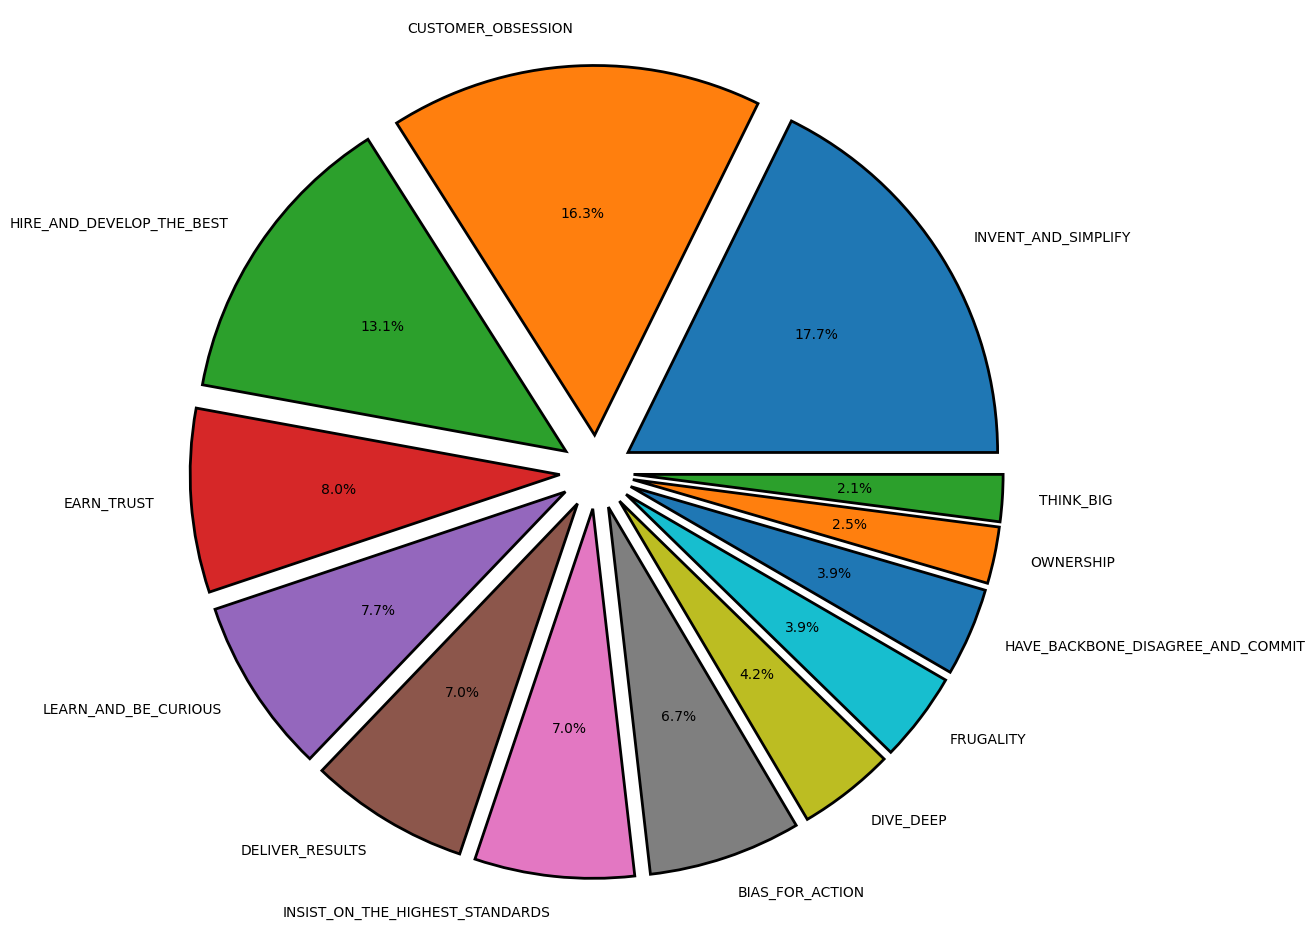

In [181]:
import matplotlib.pyplot as plt

# Create a pie chart to visualize the decomposition of the interviewee's response to the leadership principles
# The keys and values are extracted from the DECOMPOSE_RESPONSE_TO_LEADERSHIP_PRINCIPLES_SORTED dictionary

keys = []
values = []
explode = []

for item in DECOMPOSE_RESPONSE_TO_LEADERSHIP_PRINCIPLES_SORTED:
    keys.append(item[0])
    values.append(item[1])
    explode.append(0.1)

# Set the size of the figure
plt.figure(figsize=(12, 12))

# Create the pie chart with the extracted keys and values
plt.pie(values, 
        labels=keys, 
        autopct='%1.1f%%', 
        shadow=False,
        explode = explode,
        wedgeprops = {"edgecolor" : "black",
                    'linewidth' : 2,
                    'antialiased': True}, 
        startangle=0)

# Show the pie chart
plt.show()

In [52]:
import json
json.dumps(DECOMPOSE_RESPONSE_TO_LEADERSHIP_PRINCIPLES)

'{"CUSTOMER_OBSESSION": 16.288706645903027, "OWNERSHIP": 2.47402068208116, "INVENT_AND_SIMPLIFY": 17.712848082211952, "BIAS_FOR_ACTION": 6.6697614420077835, "EARN_TRUST": 8.031453808722556, "LEARN_AND_BE_CURIOUS": 7.696170057740477, "HIRE_AND_DEVELOP_THE_BEST": 13.115925768127248, "INSIST_ON_THE_HIGHEST_STANDARDS": 6.977628389653678, "THINK_BIG": 2.0516082881944118, "FRUGALITY": 3.917712584868431, "DELIVER_RESULTS": 6.992279361102819, "DIVE_DEEP": 4.22023704962294, "HAVE_BACKBONE_DISAGREE_AND_COMMIT": 3.8516478397635168}'

In [132]:
check_principles_promt =""" 
We asked a candidate an interview question. Here is the sumerized response: {candidate_response}

Context: we have different leadership principles that we want to evaluate the candidate response against.
Here is the list of leadership principles represented as a json string. Key is the leadership principle and value 
is the definition of the leadership principle.
{leadership_principles}

Question : Is candidate response relevant to this leadership principles?.

Instructions:
1) Validate your answer by highlighting the related text from the candidate response.
2) Your Response should be less than 100 words.
3) Use the format of principle name and your answer. 

For example, if you think the candidate response is relevant to the leadership principle "Customer Obsession", then your answer 
should look like "Customer Obsession": your answer. If it is not relevant, then you don't need to provide any answer. Format your answer as
a correct json string format that could be parsed by json parser."""

check_leadership_principle_prompt_template = PromptTemplate(
    input_variables =["candidate_response", "leadership_principles"],
    template = check_principles_promt
)

LEADERSHIP_PRINCIPLES_JSON = json.dumps(LEADERSHIP_PRINCIPLES)

validate_prompt = check_leadership_principle_prompt_template.format(
    candidate_response = summerized_text,
    leadership_principles = LEADERSHIP_PRINCIPLES_JSON)

import json

# The path to the JSON file
path = "response_1.json"

# Save the string to the JSON file
with open(path, "w") as f:
    json.dump(llm(validate_prompt), f, indent=4) 



In [180]:
import gradio as gr

with gr.Blocks() as coach_gpt_gradio_ui:
    gr.Markdown(
    """
    # Welcome to the AI Behavioral Interviewer for Software Engineers, Managers and Product engineers 🎤
    
    ## 📝 Instructions :

    1) Click on the button "Generate Random Question" to generate a random question.
    2) Click on the button "Evaluate By AI Interviewer" to evaluate the candidate response.
    
    ## 📊 AI Analysis Inerpretation :
    
    The evaluation result will be displayed in the text box "General Evaluation" and "Details Considering Different 
    Leadership Principles". The decomposed response to leadership principles will be displayed in the image part using cosine 
    similarity for more insigths. It gives you a sense of how the candidate response is related/ranked to different leadership 
    principles. 
    
    """)
    with gr.Column():
        btn_random_question = gr.Button("Generate Random Question")
        random_question = gr.Textbox(label="Behavioral Interview Question", )
        candidate_response = gr.Textbox(label="Candidate Response", lines=15)
        evaluate_by_ai = gr.Button("Evaluate By AI Interviewer")
        ai_evaluation = gr.Textbox(label= 'General Evaluation', lines=15)
        ai_detailed_evaluation = gr.Textbox(label= 'Details Considering Different Leadership Principles', lines=15)
        ai_similarity_analysis= gr.Plot(label="Decompisition your response to leadership principles using cosine similarity", type = "numpy")

        def generate_random_question():
            return INTERVIEW_QUESTION

        btn_random_question.click(fn=generate_random_question, 
                                  outputs=[random_question], 
                                  api_name="generate_random_question")

        def evaluate_by_ai_interviewer(random_question, candidate_response):
            return {candidate_response:'hello world', 
                    ai_evaluation:'sdfhsdghsdgh',
                    ai_detailed_evaluation:'gcfhfdfd',
                    ai_similarity_analysis: graph_numpy}

        evaluate_by_ai.click(fn=evaluate_by_ai_interviewer, 
                  inputs=[random_question, candidate_response], 
                  outputs = [ai_evaluation, ai_detailed_evaluation, ai_similarity_analysis, ai_similarity_analysis], 
                  api_name="evaluate_by_ai_interviewer")

coach_gpt_gradio_ui.launch(width=600, 
                           height=400)



/var/folders/yz/9tg9c0h12kzc99h6142015hr0000gn/T/ipykernel_30844/1475207711.py:28: GradioUnusedKwargWarning: You have unused kwarg parameters in Plot, please remove them: {'type': 'numpy'}
  ai_similarity_analysis= gr.Plot(label="Decompisition your response to leadership principles using cosine similarity", type = "numpy")


Running on local URL:  http://127.0.0.1:7914

To create a public link, set `share=True` in `launch()`.
